<a href="https://colab.research.google.com/github/devdastl/-EVA-8_Phase-1_Assignment-4/blob/main/step_2/EVA_assignment_4_step2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Second code version setup in building the Neural Network
## **Target**
Following are the targets for second code setup.
 1. Improve overall train and test accuracy.
 2. Improve model overfitting i.e. reduce difference between train and test accuracy.
 3. Introduce very necessary component known as "batch normalization" in the CNN architecture


## **Result**
Below are the results of second code setup.
1. Total number of parameters - `9,930 (<10k)` (small increase due to Batch norm learnable mean and standerd deviation)
1. Training accuracy at 15th epoch - `99.55%`
1. Testing accuracy at 15th epoch - `99.36%`
1. Training accuracy at 20th epoch - `99.62%`
1. Testing accuracy at 20th epoch - `99.43%` 

## **Analysis**
Following are the analysis of this second code setup:
1. Over all accuracy of train and test dataset has been improved by alot (train: 98.81 to 99.55, test: 98.62 to 99.36)while using "Batch Normalization" in CNN architecture compared to the first setup.
2. "Batch Normalization" normalizes feature map across batches in each layer hence fixing the distribution of data.
3. There is still exist the problem of overfitting as training accuracy is still larger then testing accruacy although the gap is now smaller comare to first setup.
4. We didn't reach the target of 99.4% test accuracy in the second code setup.
5. Parameter counts increased by ~150 after adding batch norm because batch norm introduce new learnable parameters i.e. mean and std (alpha, beta).

## Import Libraries

In [1]:
from __future__ import print_function
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms

## Data Transformations
We will start with basic transformation like normalizing the image and converting the image into pytorch Tensor.
- First transform convert dataset into pytorch tensor.
- Second transform will normalize the image by using mean and standerd deviation of complete dataset. We can use numpy to calculate this values as shown in cell 5.

output of cell 5 after commenting `transforms.Normalize` transformation.
```
[Train]
 - Numpy Shape: (60000, 28, 28)
 - Tensor Shape: torch.Size([60000, 28, 28])
 - min: tensor(0.)
 - max: tensor(1.)
 - "mean: tensor(0.1307)"
 - "std: tensor(0.3081)"
 - var: tensor(0.0949)
torch.Size([128, 1, 28, 28])
torch.Size([128])
```
As shown above it gives values 0.1307 as mean and 0.3081 as standerd deviation.

In [2]:
# Train Phase transformations
train_transforms = transforms.Compose([
                                       transforms.ToTensor(),
                                       transforms.Normalize((0.1307,), (0.3081,)) 
                                       ])

# Test Phase transformations
test_transforms = transforms.Compose([
                                       transforms.ToTensor(),
                                       transforms.Normalize((0.1307,), (0.3081,))
                                       ])


## Dataset and Creating Train/Test Split
Here we are creating pytorch dataset set class for train and test set.

In [3]:
train = datasets.MNIST('./data', train=True, download=True, transform=train_transforms)
test = datasets.MNIST('./data', train=False, download=True, transform=test_transforms)

  0%|          | 0/9912422 [00:00<?, ?it/s]

Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw



  0%|          | 0/28881 [00:00<?, ?it/s]

Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw



  0%|          | 0/1648877 [00:00<?, ?it/s]

Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw



  0%|          | 0/4542 [00:00<?, ?it/s]

Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw



## GPU and data loader setup
In below cell first we are checking if cuda devices(GPU) are available as well as we are setting up data loader for train and test set which will create batches of the set for training.

In [4]:
SEED = 1

# CUDA?
cuda = torch.cuda.is_available()
print("CUDA Available?", cuda)

# For reproducibility
torch.manual_seed(SEED)

if cuda:
    torch.cuda.manual_seed(SEED)

# dataloader arguments - something you'll fetch these from cmdprmt
dataloader_args = dict(shuffle=True, batch_size=128, num_workers=4, pin_memory=True) if cuda else dict(shuffle=True, batch_size=64)

# train dataloader
train_loader = torch.utils.data.DataLoader(train, **dataloader_args)

# test dataloader
test_loader = torch.utils.data.DataLoader(test, **dataloader_args)

CUDA Available? False


## Data Statistics and Data visualization
Here we will look at some information about the data as well as we will visualize it to get more information about our data

/usr/local/lib/python3.8/dist-packages/torchvision/datasets/mnist.py:75: UserWarning: train_data has been renamed data
  warnings.warn("train_data has been renamed data")


[Train]
 - Numpy Shape: (60000, 28, 28)
 - Tensor Shape: torch.Size([60000, 28, 28])
 - min: tensor(-0.4242)
 - max: tensor(2.8215)
 - mean: tensor(-0.0001)
 - std: tensor(1.0000)
 - var: tensor(1.0001)
torch.Size([64, 1, 28, 28])
torch.Size([64])


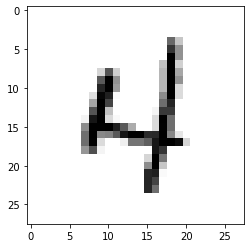

In [5]:
# We'd need to convert it into Numpy! Remember above we have converted it into tensors already
train_data = train.train_data
train_data = train.transform(train_data.numpy())

print('[Train]')
print(' - Numpy Shape:', train.train_data.cpu().numpy().shape)
print(' - Tensor Shape:', train.train_data.size())
print(' - min:', torch.min(train_data))
print(' - max:', torch.max(train_data))
print(' - mean:', torch.mean(train_data))
print(' - std:', torch.std(train_data))
print(' - var:', torch.var(train_data))

dataiter = iter(train_loader)
images, labels = next(dataiter)

print(images.shape)
print(labels.shape)

# Let's visualize some of the images
%matplotlib inline
import matplotlib.pyplot as plt

plt.imshow(images[0].numpy().squeeze(), cmap='gray_r')


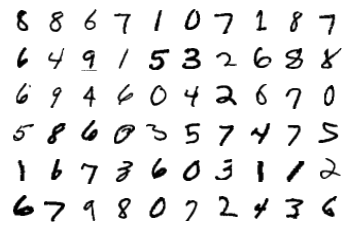

In [6]:
figure = plt.figure()
num_of_images = 60
for index in range(1, num_of_images + 1):
    plt.subplot(6, 10, index)
    plt.axis('off')
    plt.imshow(images[index].numpy().squeeze(), cmap='gray_r')

## Model architecture
Here the CNN model just uses convolution, pooling and activation. One focus while building this architecture is to keep the parameters under 10k.
Model architecture is also shown in the github README.

NOTE: Here we have introduced `nn.BatchNorm2d()` in each layer for performing batch normalization.

In [7]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        
      # First block of CNN--------------
        self.layer1 = nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels=10, kernel_size=(3, 3), padding=0, bias=False),
            nn.BatchNorm2d(10),
            nn.ReLU()
        ) # output_size = 26
        self.layer2 = nn.Sequential(
            nn.Conv2d(in_channels=10, out_channels=14, kernel_size=(3, 3), padding=0, bias=False),
            nn.BatchNorm2d(14),
            nn.ReLU()
        ) # output_size = 24
        self.layer3 = nn.Sequential(
            nn.Conv2d(in_channels=14, out_channels=16, kernel_size=(3, 3), padding=0, bias=False),
            nn.BatchNorm2d(16),
            nn.ReLU()
        ) # output_size = 22

        # TRANSITION BLOCK 1
        self.pool1 = nn.MaxPool2d(2, 2) # output_size = 11
        self.layer4 = nn.Sequential(
            nn.Conv2d(in_channels=16, out_channels=10, kernel_size=(1, 1), padding=0, bias=False),
            nn.BatchNorm2d(10),
            nn.ReLU()
        ) # output_size = 11

        # Second block of CNN---------------
        self.layer5 = nn.Sequential(
            nn.Conv2d(in_channels=10, out_channels=16, kernel_size=(3, 3), padding=0, bias=False),
            nn.BatchNorm2d(16),
            nn.ReLU()
        ) # output_size = 9

        # Third block of CNN---------------
        self.layer6 = nn.Sequential(
            nn.Conv2d(in_channels=16, out_channels=16, kernel_size=(3, 3), padding=0, bias=False),
            nn.BatchNorm2d(16),
            nn.ReLU()
        ) # output_size = 7

        # Forth block of CNN---------------
        self.layer7 = nn.Sequential(
            nn.Conv2d(in_channels=16, out_channels=16, kernel_size=(3, 3), padding=0, bias=False),
            nn.BatchNorm2d(16),
            nn.ReLU()
        ) # output_size = 5
        self.layer8 = nn.Sequential(
            nn.Conv2d(in_channels=16, out_channels=10, kernel_size=(1, 1), padding=0, bias=False),
        ) # output_size = 5

        self.gap = nn.Sequential(
            nn.AvgPool2d(kernel_size=5)
        ) # output_size = 1x1x10 



    def forward(self, x):
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.pool1(x)
        x = self.layer4(x)
        x = self.layer5(x)
        x = self.layer6(x)
        x = self.layer7(x)
        x = self.layer8(x)

        x=self.gap(x)
        x = x.view(-1, 10)
        return F.log_softmax(x, dim=-1)

# Model visualization
Here we are using external tool `torchsummary` to visualize our model architecture as well as the number of paramters (which are under 10k).

In [8]:
!pip install torchsummary
from torchsummary import summary
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
print(device)
model = Net().to(device)
summary(model, input_size=(1, 28, 28))

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
cpu
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 10, 26, 26]              90
       BatchNorm2d-2           [-1, 10, 26, 26]              20
              ReLU-3           [-1, 10, 26, 26]               0
            Conv2d-4           [-1, 14, 24, 24]           1,260
       BatchNorm2d-5           [-1, 14, 24, 24]              28
              ReLU-6           [-1, 14, 24, 24]               0
            Conv2d-7           [-1, 16, 22, 22]           2,016
       BatchNorm2d-8           [-1, 16, 22, 22]              32
              ReLU-9           [-1, 16, 22, 22]               0
        MaxPool2d-10           [-1, 16, 11, 11]               0
           Conv2d-11           [-1, 10, 11, 11]             160
      BatchNorm2d-12           [-1, 10, 11, 11]              20


# Training and Testing

In this cell we have writtern training and testing loop which will go through each batch of loader and will perfrom a forward pass and then gradient calcuation.

In [9]:
from tqdm import tqdm

train_losses = []
test_losses = []
train_acc = []
test_acc = []

def train(model, device, train_loader, optimizer, epoch):
  model.train()
  pbar = tqdm(train_loader)
  correct = 0
  processed = 0
  for batch_idx, (data, target) in enumerate(pbar):
    # get samples
    data, target = data.to(device), target.to(device)

    # Init
    optimizer.zero_grad()
    # In PyTorch, we need to set the gradients to zero before starting to do backpropragation because PyTorch accumulates the gradients on subsequent backward passes. 
    # Because of this, when you start your training loop, ideally you should zero out the gradients so that you do the parameter update correctly.

    # Predict
    y_pred = model(data)

    # Calculate loss
    loss = F.nll_loss(y_pred, target)
    train_losses.append(loss)

    # Backpropagation
    loss.backward()
    optimizer.step()

    # Update pbar-tqdm
    
    pred = y_pred.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
    correct += pred.eq(target.view_as(pred)).sum().item()
    processed += len(data)

    pbar.set_description(desc= f'Loss={loss.item()} Batch_id={batch_idx} Accuracy={100*correct/processed:0.2f}')
    train_acc.append(100*correct/processed)

def test(model, device, test_loader):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += F.nll_loss(output, target, reduction='sum').item()  # sum up batch loss
            pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)
    test_losses.append(test_loss)

    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.2f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))
    
    test_acc.append(100. * correct / len(test_loader.dataset))

## Model training
Here we will loop through epoch and call our train and test functions which we have already defined.

In [10]:
model =  Net().to(device)
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)
EPOCHS = 20
for epoch in range(EPOCHS):
    print("EPOCH:", epoch)
    train(model, device, train_loader, optimizer, epoch)
    test(model, device, test_loader)

EPOCH: 0


Loss=0.08542699366807938 Batch_id=937 Accuracy=92.39: 100%|██████████| 938/938 [00:46<00:00, 20.04it/s]



Test set: Average loss: 0.0577, Accuracy: 9840/10000 (98.40%)

EPOCH: 1


Loss=0.024629956111311913 Batch_id=937 Accuracy=98.49: 100%|██████████| 938/938 [00:46<00:00, 20.12it/s]



Test set: Average loss: 0.0534, Accuracy: 9842/10000 (98.42%)

EPOCH: 2


Loss=0.01434935163706541 Batch_id=937 Accuracy=98.78: 100%|██████████| 938/938 [00:45<00:00, 20.73it/s]



Test set: Average loss: 0.0391, Accuracy: 9881/10000 (98.81%)

EPOCH: 3


Loss=0.037220317870378494 Batch_id=937 Accuracy=98.94: 100%|██████████| 938/938 [00:44<00:00, 20.97it/s]



Test set: Average loss: 0.0321, Accuracy: 9900/10000 (99.00%)

EPOCH: 4


Loss=0.012354693375527859 Batch_id=937 Accuracy=99.09: 100%|██████████| 938/938 [00:44<00:00, 20.90it/s]



Test set: Average loss: 0.0247, Accuracy: 9915/10000 (99.15%)

EPOCH: 5


Loss=0.018275072798132896 Batch_id=937 Accuracy=99.12: 100%|██████████| 938/938 [00:46<00:00, 20.33it/s]



Test set: Average loss: 0.0231, Accuracy: 9929/10000 (99.29%)

EPOCH: 6


Loss=0.0019436324946582317 Batch_id=937 Accuracy=99.19: 100%|██████████| 938/938 [00:46<00:00, 20.12it/s]



Test set: Average loss: 0.0230, Accuracy: 9923/10000 (99.23%)

EPOCH: 7


Loss=0.014378460124135017 Batch_id=937 Accuracy=99.32: 100%|██████████| 938/938 [00:47<00:00, 19.82it/s]



Test set: Average loss: 0.0265, Accuracy: 9910/10000 (99.10%)

EPOCH: 8


Loss=0.006436615716665983 Batch_id=937 Accuracy=99.36: 100%|██████████| 938/938 [00:47<00:00, 19.79it/s]



Test set: Average loss: 0.0237, Accuracy: 9924/10000 (99.24%)

EPOCH: 9


Loss=0.037311989814043045 Batch_id=937 Accuracy=99.38: 100%|██████████| 938/938 [00:46<00:00, 20.36it/s]



Test set: Average loss: 0.0199, Accuracy: 9930/10000 (99.30%)

EPOCH: 10


Loss=0.014470784924924374 Batch_id=937 Accuracy=99.39: 100%|██████████| 938/938 [00:44<00:00, 20.87it/s]



Test set: Average loss: 0.0227, Accuracy: 9930/10000 (99.30%)

EPOCH: 11


Loss=0.007121761329472065 Batch_id=937 Accuracy=99.47: 100%|██████████| 938/938 [00:45<00:00, 20.74it/s]



Test set: Average loss: 0.0185, Accuracy: 9940/10000 (99.40%)

EPOCH: 12


Loss=0.0007072731386870146 Batch_id=937 Accuracy=99.52: 100%|██████████| 938/938 [00:45<00:00, 20.79it/s]



Test set: Average loss: 0.0204, Accuracy: 9933/10000 (99.33%)

EPOCH: 13


Loss=0.005622611381113529 Batch_id=937 Accuracy=99.52: 100%|██████████| 938/938 [00:45<00:00, 20.50it/s]



Test set: Average loss: 0.0229, Accuracy: 9920/10000 (99.20%)

EPOCH: 14


Loss=0.004204961471259594 Batch_id=937 Accuracy=99.47: 100%|██████████| 938/938 [00:45<00:00, 20.42it/s]



Test set: Average loss: 0.0215, Accuracy: 9928/10000 (99.28%)

EPOCH: 15


Loss=0.002854009624570608 Batch_id=937 Accuracy=99.55: 100%|██████████| 938/938 [00:45<00:00, 20.54it/s]



Test set: Average loss: 0.0195, Accuracy: 9936/10000 (99.36%)

EPOCH: 16


Loss=0.002017443999648094 Batch_id=937 Accuracy=99.60: 100%|██████████| 938/938 [00:45<00:00, 20.42it/s]



Test set: Average loss: 0.0213, Accuracy: 9935/10000 (99.35%)

EPOCH: 17


Loss=0.03696153312921524 Batch_id=937 Accuracy=99.58: 100%|██████████| 938/938 [00:46<00:00, 20.18it/s]



Test set: Average loss: 0.0195, Accuracy: 9936/10000 (99.36%)

EPOCH: 18


Loss=0.0029651254881173372 Batch_id=937 Accuracy=99.60: 100%|██████████| 938/938 [00:46<00:00, 20.22it/s]



Test set: Average loss: 0.0233, Accuracy: 9925/10000 (99.25%)

EPOCH: 19


Loss=0.0028057529125362635 Batch_id=937 Accuracy=99.62: 100%|██████████| 938/938 [00:46<00:00, 20.37it/s]



Test set: Average loss: 0.0192, Accuracy: 9943/10000 (99.43%)



## Result visualization
Here we will visualize or plot graphs for train and test loss and accuracy with respect to the number of iteration. (1 iteration = pass from 1 batch)

In [11]:
import numpy as np
train_loss_list = np.array([num.item() for num in train_losses ])


Text(0.5, 1.0, 'Test Accuracy')

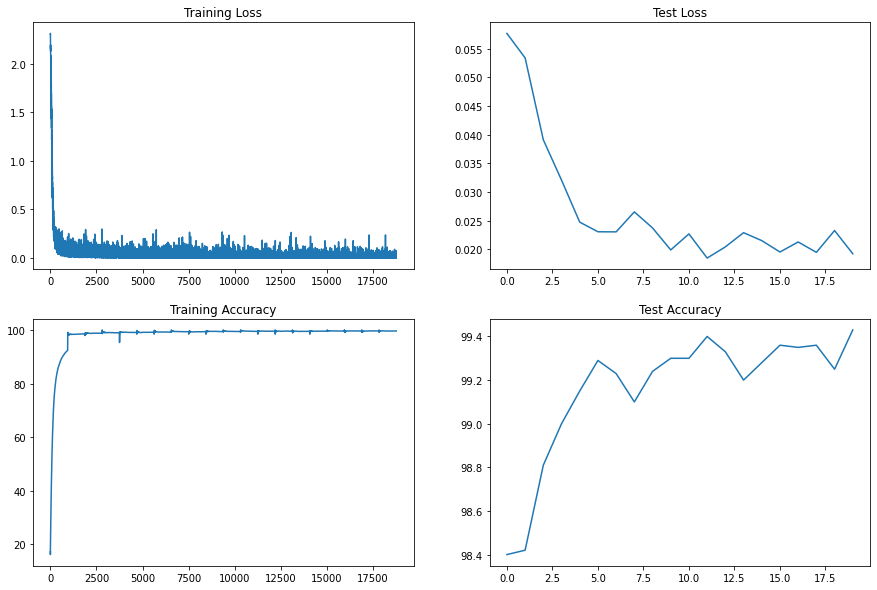

In [12]:
fig, axs = plt.subplots(2,2,figsize=(15,10))
axs[0, 0].plot(train_loss_list)
axs[0, 0].set_title("Training Loss")
axs[1, 0].plot(train_acc)
axs[1, 0].set_title("Training Accuracy")
axs[0, 1].plot(test_losses)
axs[0, 1].set_title("Test Loss")
axs[1, 1].plot(test_acc)
axs[1, 1].set_title("Test Accuracy")